# Implementation
<div id="wave:pde1:impl"></div>

This section presents the complete computational algorithm, its
implementation in Python code, animation of the solution, and
verification of the implementation.

A real implementation of the basic computational algorithm from
the sections [Formulating a recursive algorithm](wave1D_fd1.ipynb#wave:string:alg) and [Sketch of an implementation](wave1D_fd1.ipynb#wave:string:impl) can be
encapsulated in a function, taking all the input data for the problem
as arguments.  The physical input data consists of $c$, $I(x)$,
$V(x)$, $f(x,t)$, $L$, and $T$.  The numerical input is the mesh
parameters $\Delta t$ and $\Delta x$.

Instead of specifying $\Delta t$ *and* $\Delta x$, we can specify one
of them and the Courant number $C$ instead, since having explicit
control of the Courant number is convenient when investigating the
numerical method. Many find it natural to prescribe the resolution of
the spatial grid and set $N_x$. The solver function can then compute
$\Delta t = CL/(cN_x)$. However, for comparing $u(x,t)$ curves (as
functions of $x$) for various Courant numbers
it is more convenient to keep $\Delta t$ fixed for
all $C$ and let $\Delta x$ vary according to $\Delta x = c\Delta t/C$.
With $\Delta t$ fixed, all frames correspond to the same time $t$,
and this simplifies animations that compare simulations with different
mesh resolutions. Plotting functions of $x$
with different spatial resolution is trivial,
so it is easier to let $\Delta x$ vary in the simulations than $\Delta t$.

## Callback function for user-specific actions
<div id="wave:pde1:impl:useraction"></div>


The solution at all spatial points at a new time level is stored in an
array `u` of length $N_x+1$. We need to decide what to do with
this solution, e.g., visualize the curve, analyze the values, or write
the array to file for later use. The decision about what to do is left to
the user in the form of a user-supplied function 
`user_action(u, x, t, n)`, where `u` is the solution at the spatial points `x` at time `t[n]`.
The `user_action` function is called from the solver at each time level `n`.

If the user wants to plot the solution or store the solution at a
time point, she needs to write such a function and take appropriate
actions inside it. We will show examples on many such `user_action`
functions.

Since the solver function makes calls back to the user's code
via such a function, this type of function is called a *callback function*.
When writing general software, like our solver function, which also needs
to carry out special problem- or solution-dependent actions
(like visualization),
it is a common technique to leave those actions to user-supplied
callback functions.

The callback function can be used to terminate the solution process
if the user returns `True`. For example,

In [2]:
def my_user_action_function(u, x, t, n):
    return np.abs(u).max() > 10

is a callback function that will terminate the solver function (given below) of the
amplitude of the waves exceed 10, which is here considered as a numerical
instability.


## The solver function
<div id="wave:pde1:impl:solver"></div>


A first attempt at a solver function is listed below.

In [1]:
import numpy as np
import time as time

def python_solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0

    u     = np.zeros(Nx+1)   # Solution array at new time level
    u_n   = np.zeros(Nx+1)   # Solution at 1 time level back
    u_nm1 = np.zeros(Nx+1)   # Solution at 2 time levels back

    t0 = time.perf_counter()  # Measure CPU time

    # Load initial condition into u_n
    for i in range(0,Nx+1):
        u_n[i] = I(x[i])

    if user_action is not None:
        user_action(u_n, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_n[i] + dt*V(x[i]) + \
               0.5*C2*(u_n[i-1] - 2*u_n[i] + u_n[i+1]) + \
               0.5*dt**2*f(x[i], t[n])
    u[0] = 0;  u[Nx] = 0

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_nm1[:] = u_n;  u_n[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_nm1[i] + 2*u_n[i] + \
                     C2*(u_n[i-1] - 2*u_n[i] + u_n[i+1]) + \
                     dt**2*f(x[i], t[n])

        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Switch variables before next step
        u_nm1[:] = u_n;  u_n[:] = u
        

    cpu_time = time.perf_counter() - t0
    return u, x, t, cpu_time

A couple of remarks about the above code is perhaps necessary:

 * Although we give `dt` and compute `dx` via `C` and `c`, the resulting
   `t` and `x` meshes do not necessarily correspond exactly to these values
   because of rounding errors. To explicitly ensure that `dx` and `dt`
   correspond to the cell sizes in `x` and `t`, we recompute the values.

 * According to the particular choice made in the section [Callback function for user-specific actions](#wave:pde1:impl:useraction), a true value returned from `user_action` should terminate the simulation. This is here implemented by a `break` statement inside the for loop in the solver.
<!-- Too trivial here: -->
<!-- Checking that a solution $u^n_i$ stays constant throughout some -->
<!-- time steps is often of considerable help in tracking down bugs -->
<!-- in an implementation. A constant solution $u = Q$ fulfills -->
<!-- the PDE problem ([wave:pde2](#wave:pde2))-([wave:pde2:bc:L](#wave:pde2:bc:L)) -->
<!-- if $I(x)=0$, $V=0$, $u(0,t)=u(L,t)=0$, and $f=0$ -->

#### Devito implementation
Now let's take a look at the same algorithm, but this time, using Devito.

In [2]:
import numpy as np
import time as time
from devito import Constant, Grid, TimeFunction, SparseTimeFunction, Function, Eq, solve, Operator, Buffer

In [6]:
# %load -s devito_solver, src-wave/wave1D/wave1D_u0.py
def devito_solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    a = Constant(name='a')

    # Set source term to 0 if not provided
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0

    # Initialise `u` for space and time order 2, using initialisation function I
    # across all values in x
    grid = Grid(shape=Nx+1, extent=L)
    u = TimeFunction(name='u', grid=grid, space_order=2, time_order=2, save=Nt)
    u.data[:] = I(x) # Forward, central and backward time steps all same - u_t(x, 0) = 0
    
    if user_action is not None:
        user_action(u.data[0], x, t, 0)
    
    dt_symbolic = grid.time_dim.spacing
    
    # Source term and injection into equation
    src = SparseTimeFunction(name='f', grid=grid, npoint=Nx+1, nt=Nt)
    src.coordinates.data[:, 0] = f(x, t)
    src_term = src.inject(field=u.forward, expr=src * dt_symbolic**2)
    
    # Measure CPU time
    t0 = time.perf_counter()
    
    # Set up wave equation and solve for forward stencil point in time
    x_dim = grid.dimensions[0]
    time_dim = grid.time_dim
    eq = Eq(u.dt2, (a**2) * u.dx2 + f(x_dim, time_dim))
    stencil = solve(eq, u.forward)
    eq_stencil = Eq(u.forward, stencil)
    
    
    # Boundary conditions
    stepping_dim = grid.stepping_dim
    bc1 = [Eq(u[stepping_dim+1, 0], 0.)]
    bc2 = [Eq(u[stepping_dim+1, Nx], 0.)]
    
    # Building operator
    op = Operator([eq_stencil] + bc1 + bc2 + src_term)
    op.apply(dt=dt.astype(np.float32), a=c)
    
    if user_action is not None:
        for i in range (1, Nt):
            user_action(u.data[i], x, t, i+1)
    
    cpu_time = time.perf_counter() - t0
    return u.data[-1], x, t, cpu_time


In [7]:
import numpy as np
import time as time
from devito import Constant, Grid, TimeFunction, SparseTimeFunction, Function, Eq, solve, Operator, Buffer

def second_devito_solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0
    
    grid = Grid(shape=(Nx+1), extent=(L))
    t_s = grid.stepping_dim
    
    u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)
    u.data[:,:] = I(x[:])

    pde = (1/c**2)*u.dt2-u.dx2
    stencil = Eq(u.forward, solve(pde, u.forward))
    
    v = Function(name='v', grid=grid)
    v.data[:] = V(x[:])

        
    # Initial timestep
#     stencil_init = stencil.subs(u.backward, u.forward - 2*t_s*v)
    stencil_init = stencil.subs(u.backward, u.forward)
    
    # Source term and injection into equation
    dt_symbolic = grid.time_dim.spacing
    src = SparseTimeFunction(name='f', grid=grid, npoint=Nx+1, nt=Nt+1)
    print(src.shape)
    src.data[:] = f(x, t)
    src.coordinates.data[:, 0] = x
    src_term = src.inject(field=u.forward, expr=src * (dt_symbolic**2)*0.5*c**2)
    src_term_init = src.inject(field=u.forward, expr=0.5*src * (dt_symbolic**2))
    
    # Boundary conditions
    bc = [Eq(u[t_s+1, 0], 0)]
    bc += [Eq(u[t_s+1, Nx], 0)]

    
    op_init = Operator([stencil_init]+src_term_init+bc)
    op = Operator([stencil]+src_term+bc)
    
    op_init.apply(time_M=1, dt=dt)
    op.apply(time_m=1, time_M=Nt, dt=dt)
    
#     print(op.ccode)
    
    return u.data[-1], x, t, 0

(1441, 101)


Data type float64 of runtime value `dt` does not match the Constant data type <class 'numpy.float32'>
Operator `Kernel` run in 0.01 s
Data type float64 of runtime value `dt` does not match the Constant data type <class 'numpy.float32'>
Operator `Kernel` run in 0.01 s


Python:


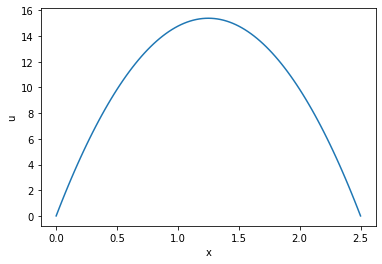

Devito:


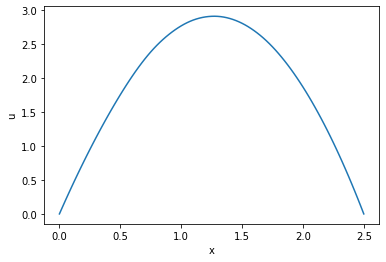

In [8]:
import matplotlib.pyplot as plt

def u_exact(x, t):
        return x*(L-x)*(1 + 0.5*t)

def I(x):
    return u_exact(x, 0)

def V(x):
    return 0.5*u_exact(x, 0)

def f(x, t):
    return 2*(1 + 0.5*t)*c**2

c = 1.5
L = 2.5
Nx = 100
C = 0.75
dt = C*(L/Nx)/c
T = 18
u_correct, x_arr_correct, t_arr_correct, cpu_time_corr = python_solver(I, None, f, c, L, dt, C, T)
u_mine, x_arr, t_arr, cpu_time = second_devito_solver(I, None, f, c, L, dt, C, T)

print("Python:")
plt.plot(x_arr_correct, u_correct)
plt.xlabel('x')
plt.ylabel('u')
plt.show()

print("Devito:")
plt.plot(x_arr, u_mine)
plt.xlabel('x')
plt.ylabel('u')
plt.show()

## Verification: exact quadratic solution
<div id="wave:pde1:impl:verify:quadratic"></div>


We use the test problem derived in the section [A slightly generalized model problem](wave1D_fd1.ipynb#wave:pde2:fd) for
verification. Below is a unit test based on this test problem
and realized as a proper *test function* compatible with the unit test
frameworks nose or pytest.

In [201]:
# %load -s test_quadratic, src-wave/wave1D/wave1D_u0.py
def test_quadratic():
    """Check that u(x,t)=x(L-x)(1+t/2) is exactly reproduced."""

    def u_exact(x, t):
        return x*(L-x)*(1 + 0.5*t)

    def I(x):
        return u_exact(x, 0)

    def V(x):
        return 0.5*u_exact(x, 0)

    def f(x, t):
        return 2*(1 + 0.5*t)*c**2

    L = 2.5
    c = 1.5
    C = 0.75
    Nx = 6  # Very coarse mesh for this exact test
    dt = C*(L/Nx)/c
    T = 18

    def assert_no_error(u, x, t, n):
        u_e = u_exact(x, t[n])
        print(np.abs(u- u_e).min())
        diff = np.abs(u - u_e).max()
        tol = 1E-7
        assert diff < tol

    devito_solver(I, V, f, c, L, dt, C, T,
           user_action=assert_no_error)


When this function resides in the file [`wave1D_u0.py`](src-wave/wave1D/wave1D_u0.py), one can run
pytest to check that all test functions with names `test_*()`
in this file work:

        Terminal> py.test -s -v wave1D_u0.py


## Verification: convergence rates
<div id="wave:pde1:impl:verify:rate"></div>


A more general method, but not so reliable as a verification method,
is to compute the convergence rates and see if they coincide with
theoretical estimates. Here we expect a rate of 2 according to
the various results in the section [Analysis of the difference equations
](wave_analysis.ipynb#wave:pde1:analysis).
A general function for computing convergence rates can be written like
this:

In [16]:
# %load -s convergence_rates, src-wave/wave1D/wave1D_u0.py
def convergence_rates(
    u_exact,                 # Python function for exact solution
    I, V, f, c, L,           # physical parameters
    dt0, num_meshes, C, T):  # numerical parameters
    """
    Half the time step and estimate convergence rates for
    for num_meshes simulations.
    """
    # First define an appropriate user action function
    global error
    error = 0  # error computed in the user action function

    def compute_error(u, x, t, n):
        global error  # must be global to be altered here
        # (otherwise error is a local variable, different
        # from error defined in the parent function)
        if n == 0:
            error = 0
        else:
            error = max(error, np.abs(u - u_exact(x, t[n])).max())

    # Run finer and finer resolutions and compute true errors
    E = []
    h = []  # dt, devito_solver adjusts dx such that C=dt*c/dx
    dt = dt0
    for i in range(num_meshes):
        devito_solver(I, V, f, c, L, dt, C, T,
               user_action=compute_error)
        # error is computed in the final call to compute_error
        E.append(error)
        h.append(dt)
        dt /= 2  # halve the time step for next simulation
    print('E:')
    print(E)
    print('h:')
    print(h)
    # Convergence rates for two consecutive experiments
    r = [np.log(E[i]/E[i-1])/np.log(h[i]/h[i-1])
         for i in range(1,num_meshes)]
    return r


Using the analytical solution from the section [Using an analytical solution of physical significance](wave1D_fd1.ipynb#wave:pde2:fd:standing:waves), we can call `convergence_rates` to
see if we get a convergence rate that approaches 2 and use the final
estimate of the rate in an `assert` statement such that this function becomes
a proper test function:

In [17]:
# %load -s test_convrate_sincos, src-wave/wave1D/wave1D_u0.py
def test_convrate_sincos():
    n = m = 2
    L = 1.0
    u_exact = lambda x, t: np.cos(m*np.pi/L*t)*np.sin(m*np.pi/L*x)

    r = convergence_rates(
        u_exact=u_exact,
        I=lambda x: u_exact(x, 0),
        V=lambda x: 0,
        f=0,
        c=1,
        L=L,
        dt0=0.1,
        num_meshes=6,
        C=0.9,
        T=1)
    print('rates sin(x)*cos(t) solution:')
    print([round(r_,2) for r_ in r])
    assert abs(r[-1] - 2) < 0.002


In [18]:
test_convrate_sincos()

Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s
Operator `Kernel` run in 0.01 s


E:
[Data(1.36646618), Data(0.98566641), Data(0.57493195), Data(0.30752397), Data(0.15659378), Data(0.07878391)]
h:
[0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125]
rates sin(x)*cos(t) solution:


TypeError: type Data doesn't define __round__ method

Doing `py.test -s -v wave1D_u0.py` will run also this test function and
show the rates 2.05, 1.98, 2.00, 2.00, and 2.00 (to two decimals).


## Visualization: animating the solution
<div id="wave:pde1:impl:animate"></div>

Now that we have verified the implementation it is time to do a
real computation where we also display evolution of the waves
on the screen. Since the `solver` function knows nothing about
what type of visualizations we may want, it calls the callback function
`user_action(u, x, t, n)`. We must therefore write this function and
find the proper statements for plotting the solution.

### Function for administering the simulation

The following `viz` function

1. defines a `user_action` callback function
   for plotting the solution at each time level,

2. calls the `solver` function, and

3. combines all the plots (in files) to video in different formats.

In [206]:
# %load -s viz, src-wave/wave1D/wave1D_u0.py
def viz(
    I, V, f, c, L, dt, C, T,  # PDE parameters
    umin, umax,               # Interval for u in plots
    animate=True,             # Simulation with animation?
    tool='matplotlib',        # 'matplotlib' or 'scitools'
    devito_solver_function=devito_solver,   # Function with numerical algorithm
    ):
    """Run devito_solver and visualize u at each time level."""

    def plot_u_st(u, x, t, n):
        """user_action function for devito_solver."""
        plt.plot(x, u, 'r-',
                 xlabel='x', ylabel='u',
                 axis=[0, L, umin, umax],
                 title='t=%f' % t[n], show=True)
        # Let the initial condition stay on the screen for 2
        # seconds, else insert a pause of 0.2 s between each plot
        time.sleep(2) if t[n] == 0 else time.sleep(0.2)
        plt.savefig('frame_%04d.png' % n)  # for movie making

    class PlotMatplotlib:
        def __call__(self, u, x, t, n):
            """user_action function for devito_solver."""
            if n == 0:
                plt.ion()
                self.lines = plt.plot(x, u, 'r-')
                plt.xlabel('x');  plt.ylabel('u')
                plt.axis([0, L, umin, umax])
                plt.legend(['t=%f' % t[n]], loc='lower left')
            else:
                self.lines[0].set_ydata(u)
                plt.legend(['t=%f' % t[n]], loc='lower left')
                plt.draw()
            time.sleep(2) if t[n] == 0 else time.sleep(0.2)
            plt.savefig('tmp_%04d.png' % n)  # for movie making

    if tool == 'matplotlib':
        import matplotlib.pyplot as plt
        plot_u = PlotMatplotlib()
    elif tool == 'scitools':
        import scitools.std as plt  # scitools.easyviz interface
        plot_u = plot_u_st
    import time, glob, os

    # Clean up old movie frames
    for filename in glob.glob('tmp_*.png'):
        os.remove(filename)

    # Call devito_solver and do the simulaton
    user_action = plot_u if animate else None
    u, x, t, cpu = devito_solver_function(
        I, V, f, c, L, dt, C, T, user_action)

    # Make video files
    fps = 4  # frames per second
    codec2ext = dict(flv='flv', libx264='mp4', libvpx='webm',
                     libtheora='ogg')  # video formats
    filespec = 'tmp_%04d.png'
    movie_program = 'ffmpeg'  # or 'avconv'
    for codec in codec2ext:
        ext = codec2ext[codec]
        cmd = '%(movie_program)s -r %(fps)d -i %(filespec)s '\
              '-vcodec %(codec)s movie.%(ext)s' % vars()
        os.system(cmd)

    if tool == 'scitools':
        # Make an HTML play for showing the animation in a browser
        plt.movie('tmp_*.png', encoder='html', fps=fps,
                  output_file='movie.html')
    return cpu


### Dissection of the code

The `viz` function can either use SciTools or Matplotlib for
visualizing the solution. The `user_action` function based on SciTools
is called `plot_u_st`, while the `user_action` function based on
Matplotlib is a bit more complicated as it is realized as a class and
needs statements that differ from those for making static plots.
SciTools can utilize both Matplotlib and Gnuplot (and many other
plotting programs) for doing the graphics, but Gnuplot is a relevant
choice for large $N_x$ or in two-dimensional problems
as Gnuplot is significantly faster than
Matplotlib for screen animations.


A function inside another function, like `plot_u_st` in the above code
segment, has access to *and remembers* all the local variables in the
surrounding code inside the `viz` function (!). This is known in
computer science as a *closure* and is very convenient to program
with. For example, the `plt` and `time` modules defined outside
`plot_u` are accessible for `plot_u_st` when the function is called
(as `user_action`) in the `solver` function.  Some may think, however,
that a class instead of a closure is a cleaner and
easier-to-understand implementation of the user action function, see
the section [Building a general 1D wave equation solver](wave1D_fd2.ipynb#wave:pde2:software).

The `plot_u_st` function just makes a standard SciTools `plot` command
for plotting `u` as a function of `x` at time `t[n]`.  To achieve a
smooth animation, the `plot` command should take keyword arguments
instead of being broken into separate calls to `xlabel`, `ylabel`,
`axis`, `time`, and `show`.  Several `plot` calls will automatically
cause an animation on the screen. In addition, we want to save each
frame in the animation to file. We then need a filename where the
frame number is padded with zeros, here `tmp_0000.png`,
`tmp_0001.png`, and so on.  The proper printf construction is then
`tmp_%04d.png`. The section [Making animations](../01_vib/vib_undamped.ipynb#vib:ode1:anim) contains more basic
information on making animations.

The solver is called with an argument `plot_u` as `user_function`.
If the user chooses to use SciTools, `plot_u` is the `plot_u_st`
callback function, but for Matplotlib it is an instance of the
class `PlotMatplotlib`. Also this class makes use of variables
defined in the `viz` function: `plt` and `time`.
With Matplotlib, one has to make the first plot the standard way, and
then update the $y$ data in the plot at every time level. The update
requires active use of the returned value from `plt.plot` in the first
plot.  This value would need to be stored in a local variable if we
were to use a closure for the `user_action` function when doing the
animation with Matplotlib. mathcal{I}_t is much easier to store the
variable as a class attribute `self.lines`. Since the class is essentially a
function, we implement the function as the special method `__call__`
such that the instance `plot_u(u, x, t, n)` can be called as a standard
callback function from `solver`.

### Making movie files

From the
`frame_*.png` files containing the frames in the animation we can
make video files.
% if BOOK == "book":
the section [vib:ode1:anim](#vib:ode1:anim) presents basic information on how to
use the `ffmpeg` (or `avconv`) program for producing video files
in different modern formats: Flash, MP4, Webm, and Ogg.
% else:
We use the `ffmpeg` (or `avconv`) program to combine individual
plot files to movies in modern formats: Flash, MP4, Webm, and Ogg.
A typical `ffmpeg` (or `avconv`) command for creating a movie file
in Ogg format
with 4 frames per second built from a collection of
plot files with names generated by `frame_%04d.png`,
look like

        Terminal> ffmpeg -r 25 -i frame_%04d.png -c:v libtheora movie.ogg


The different formats require different video encoders (`-c:v`) to
be installed: Flash applies `flv`, WebM applies `libvpx`, and MP4
applies `libx264`:

        Terminal> ffmpeg -r 25 -i frame_%04d.png -c:v flv movie.flv
        Terminal> ffmpeg -r 25 -i frame_%04d.png -c:v libvpx movie.webm
        Terminal> ffmpeg -r 25 -i frame_%04d.png -c:v libx264 movie.mp4


Players like `vlc`, `mplayer`, `gxine`, and `totem`
can be used to play these movie files.

Note that padding the frame counter with zeros in the `frame_*.png`
files, as specified by the `%04d` format, is essential so that the wildcard
notation `frame_*.png` expands to the correct set of files.
% endif


The `viz` function creates an `ffmpeg` or `avconv` command
with the proper arguments for each of the formats Flash, MP4, WebM,
and Ogg. The task is greatly simplified by having a
`codec2ext` dictionary for mapping
video codec names to filename extensions.
% if BOOK == "book":
As mentioned in the section [vib:ode1:anim](#vib:ode1:anim), only
% else:
Only
% endif
two formats are actually needed to ensure that all browsers can
successfully play the video: MP4 and WebM.

Some animations having a large number of plot files may not
be properly combined into a video using `ffmpeg` or `avconv`.
A method that always works is to play the PNG files as an animation
in a browser using JavaScript code in an HTML file.
The SciTools package has a function `movie` (or a stand-alone command
`scitools movie`) for creating such an HTML player. The `plt.movie`
call in the `viz` function shows how the function is used.
The file `movie.html` can be loaded into a browser and features
a user interface where the speed of the animation can be controlled.
Note that the movie in this case consists of the `movie.html` file
and all the frame files `tmp_*.png`.


### Skipping frames for animation speed

Sometimes the time step is small and $T$ is large, leading to an
inconveniently large number of plot files and a slow animation on the
screen. The solution to such a problem is to decide on a total number
of frames in the animation, `num_frames`, and plot the solution only for
every `skip_frame` frames. For example, setting `skip_frame=5` leads
to plots of every 5 frames. The default value `skip_frame=1` plots
every frame.
The total number of time levels (i.e., maximum
possible number of frames) is the length of `t`, `t.size` (or `len(t)`),
so if we want `num_frames` frames in the animation,
we need to plot every `t.size/num_frames` frames:

```python
def plot_u(t):
    skip_frame = int(t.size/float(num_frames))
    if n % skip_frame == 0 or n == t.size-1:
        st.plot(x, u, 'r-', ...)
```

The initial condition (`n=0`) is included by `n % skip_frame == 0`,
as well as every `skip_frame`-th frame.
As `n % skip_frame == 0` will very seldom be true for the
very final frame, we must also check if `n == t.size-1` to
get the final frame included.

A simple choice of numbers may illustrate the formulas: say we have
801 frames in total (`t.size`) and we allow only 60 frames to be
plotted. As `n` then runs from 801 to 0, we need to plot every 801/60
frame, which with integer division yields 13 as `skip_frame`. Using
the mod function, `n % skip_frame`, this operation is zero every time
`n` can be divided by 13 without a remainder. That is, the `if` test
is true when `n` equals $0, 13, 26, 39, ..., 780, 801$. The associated
code is included in the `plot_u` function, inside the `viz` function,
in the file [`wave1D_u0.py`](src-wave/wave1D/wave1D_u0.py).

## Running a case
<div id="wave:pde1:guitar:data"></div>

The first demo of our 1D wave equation solver concerns vibrations of a
string that is initially deformed to a triangular shape, like when picking
a guitar string:

<!-- Equation labels as ordinary links -->
<div id="wave:pde1:guitar:I"></div>

$$
\begin{equation}
I(x) = \left\lbrace
\begin{array}{ll}
ax/x_0, & x < x_0,\\ 
a(L-x)/(L-x_0), & \hbox{otherwise}
\end{array}\right.
\label{wave:pde1:guitar:I} \tag{1}
\end{equation}
$$

We choose $L=75$ cm, $x_0=0.8L$, $a=5$ mm, and a time frequency
$\nu = 440$ Hz. The relation between the wave speed $c$ and $\nu$ is
$c=\nu\lambda$, where $\lambda$ is the wavelength, taken as $2L$ because
the longest wave on the string forms frac{1}{2} a wavelength. There is no
external force, so $f=0$ (meaning we can neglect gravity),
and the string is at rest initially, implying $V=0$.

Regarding numerical parameters, we need to specify a $\Delta t$.
Sometimes it is more natural to think of a spatial resolution instead
of a time step. A natural semi-coarse spatial resolution in the present
problem is $N_x=50$. We can then choose the associated $\Delta t$ (as required
by the `viz` and `solver` functions) as the stability limit:
$\Delta t = L/(N_xc)$. This is the $\Delta t$ to be specified,
but notice that if $C<1$, the actual $\Delta x$ computed in `solver` gets
larger than $L/N_x$: $\Delta x = c\Delta t/C = L/(N_xC)$. (The reason
is that we fix $\Delta t$ and adjust $\Delta x$, so if $C$ gets
smaller, the code implements this effect in terms of a larger $\Delta x$.)

A function for setting the physical and numerical parameters and
calling `viz` in this application goes as follows:

In [ ]:
# %load -s guitar, src-wave/wave1D/wave1D_u0.py
def guitar(C):
    """Triangular wave (pulled guitar string)."""
    L = 0.75
    x0 = 0.8*L
    a = 0.005
    freq = 440
    wavelength = 2*L
    c = freq*wavelength
    omega = 2*pi*freq
    num_periods = 1
    T = 2*pi/omega*num_periods
    # Choose dt the same as the stability limit for Nx=50
    dt = L/50./c

    def I(x):
        return a*x/x0 if x < x0 else a/(L-x0)*(L-x)

    umin = -1.2*a;  umax = -umin
    cpu = viz(I, 0, 0, c, L, dt, C, T, umin, umax,
              animate=True, tool='scitools')


The associated program has the name [`wave1D_u0.py`](src-wave/wave1D/wave1D_u0.py). Run
the program and watch the [movie of the vibrating string](mov-wave/guitar_C0.8/movie.html).
The string should ideally consist of straight segments, but these are
somewhat wavy due to numerical approximation. Run the case with the
`wave1D_u0.py` code and $C=1$ to see the exact solution.


## Working with a scaled PDE model


Depending on the model, it may be a substantial job to establish
consistent and relevant physical parameter values for a case.  The
guitar string example illustrates the point.  However, by *scaling*
the mathematical problem we can often reduce the need to estimate
physical parameters dramatically. The scaling technique consists of
introducing new independent and dependent variables, with the aim that
the absolute values of these lie in $[0,1]$. We introduce the
dimensionless variables (details are found in Section 3.1.1 in [[Langtangen_scaling]](#Langtangen_scaling))

$$
\bar x = \frac{x}{L},\quad \bar t = \frac{c}{L}t,\quad
\bar u = \frac{u}{a}
$$

Here, $L$ is a typical length scale, e.g., the length of the domain,
and $a$ is a typical size of $u$, e.g., determined from the
initial condition: $a=\max_x|I(x)|$.

We get by the chain rule that

$$
\frac{\partial u}{\partial t} =
\frac{\partial}{\partial\bar t}\left(a\bar u\right)
\frac{d\bar t}{dt} =
\frac{ac}{L}\frac{\partial\bar u}{\partial\bar t}
$$

Similarly,

$$
\frac{\partial u}{\partial x}
= \frac{a}{L}\frac{\partial\bar u}{\partial\bar x}
$$

Inserting the dimensionless variables in the PDE gives, in case $f=0$,

$$
\frac{a^2c^2}{L^2}\frac{\partial^2\bar u}{\partial\bar t^2}
= \frac{a^2c^2}{L^2}\frac{\partial^2\bar u}{\partial\bar x^2}
$$

Dropping the bars, we arrive at the scaled PDE

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2},
\quad x\in (0,1),\ t\in (0,cT/L),
\label{_auto1} \tag{2}
\end{equation}
$$

which has no parameter $c^2$ anymore. The initial conditions are scaled
as

$$
a\bar u(\bar x, 0) = I(L\bar x)
$$

and

$$
\frac{a}{L/c}\frac{\partial\bar u}{\partial\bar t}(\bar x,0) = V(L\bar x),
$$

resulting in

$$
\bar u(\bar x, 0) = \frac{I(L\bar x)}{\max_x |I(x)|},\quad
\frac{\partial\bar u}{\partial\bar t}(\bar x,0) = \frac{L}{ac}V(L\bar x)
$$

In the common case $V=0$ we see that there are no physical parameters to be
estimated in the PDE model!

If we have a program implemented for the physical wave equation with
dimensions, we can obtain the dimensionless, scaled version by
setting $c=1$. The initial condition of a guitar string,
given in ([1](#wave:pde1:guitar:I)), gets its scaled form by choosing
$a=1$, $L=1$, and $x_0\in [0,1]$. This means that we only need to
decide on the $x_0$ value as a fraction of unity, because
the scaled problem corresponds to setting all
other parameters to unity. In the code we can just set
`a=c=L=1`, `x0=0.8`, and there is no need to calculate with
wavelengths and frequencies to estimate $c$!

The only non-trivial parameter to estimate in the scaled problem
is the final end time of the simulation, or more precisely, how it relates
to periods in periodic solutions in time, since we often want to
express the end time as a certain number of periods.
The period in the dimensionless problem is 2, so the end time can be
set to the desired number of periods times 2.

Why the dimensionless period is 2 can be explained by the following
reasoning.
Suppose that $u$ behaves as $\cos (\omega t)$ in time in the original
problem with dimensions. The corresponding period is then $P=2\pi/\omega$, but
we need to estimate $\omega$. A typical solution of the wave
equation is $u(x,t)=A\cos(kx)\cos(\omega t)$, where $A$ is an amplitude
and $k$ is related to the wave length $\lambda$ in space: $\lambda = 2\pi/k$.
Both $\lambda$ and $A$ will be given by the initial condition $I(x)$.
Inserting this $u(x,t)$ in the PDE yields $-\omega^2 = -c^2k^2$, i.e.,
$\omega = kc$. The period is therefore $P=2\pi/(kc)$.
If the boundary conditions are $u(0,t)=u(L,t)$, we need to have
$kL = n\pi$ for integer $n$. The period becomes $P=2L/nc$. The longest
period is $P=2L/c$. The dimensionless period $\tilde P$ is obtained
by dividing $P$ by the time scale $L/c$, which results in $\tilde P=2$.
Shorter waves in the initial condition will have a dimensionless
shorter period $\tilde P=2/n$ ($n>1$).


# Exercises



<!-- --- begin exercise --- -->

## Exercise 1: Simulate a standing wave
<div id="wave:exer:standingwave"></div>

The purpose of this exercise is to simulate standing waves on $[0,L]$
and illustrate the error in the simulation.
Standing waves arise from an initial condition

$$
u(x,0)= A \sin\left(\frac{\pi}{L}mx\right),
$$

where $m$ is an integer and $A$ is a freely chosen amplitude.
The corresponding exact solution can be computed and reads

$$
u(x,t) =  A\sin\left(\frac{\pi}{L}mx\right)
\cos\left(\frac{\pi}{L}mct\right)
$$

**a)**
Explain that for a function $\sin kx\cos \omega t$ the wave length
in space is $\lambda = 2\pi /k$ and the period in time is $P=2\pi/\omega$.
Use these expressions to find the wave length in space and period in
time of $u$ above.


<!-- --- begin solution of exercise --- -->
**Solution.**
Since the sin and cos functions depend on $x$ and $t$, respectively,
the sin function will run through one period as $x$ increases by $\frac{2\pi}{k}$, while the cos function starts repeating as $t$ increases by $\frac{2\pi}{\omega}$.

The wave length in space becomes

$$
\lambda =  \frac{2\pi}{\frac{\pi}{L}m} = \frac{2L}{m}
$$

The period in time becomes

$$
P =  \frac{2\pi}{\frac{\pi}{L}mc} = \frac{2L}{mc}
$$

<!-- --- end solution of exercise --- -->

**b)**
Import the `solver` function from `wave1D_u0.py` into a new file
where the `viz` function is reimplemented such that it
plots either the numerical *and* the exact solution, *or* the error.


<!-- --- begin solution of exercise --- -->
**Solution.**
See code below.

<!-- --- end solution of exercise --- -->

**c)**
Make animations where you illustrate how the error
$e^n_i =u(x_i, t_n)- u^n_i$
develops and increases in time. Also make animations of
$u$ and $u$ simultaneously.

<!-- --- begin hint in exercise --- -->

**Hint 1.**
Quite long time simulations are needed in order to display significant
discrepancies between the numerical and exact solution.

<!-- --- end hint in exercise --- -->

<!-- --- begin hint in exercise --- -->

**Hint 2.**
A possible set of parameters is $L=12$, $m=9$, $c=2$, $A=1$, $N_x=80$,
$C=0.8$. The error mesh function $e^n$ can be simulated for 10 periods,
while 20-30 periods are needed to show significant differences between
the curves for the numerical and exact solution.

<!-- --- end hint in exercise --- -->


<!-- --- begin solution of exercise --- -->
**Solution.**
The code:

```python
import sys
sys.path.insert(1, "src-wave/wave1D")

from wave1D_u0 import devito_solver
#from wave1D_u0v import devito_solver  # allows faster vectorized operations
import numpy as np

def viz(I, V, f, c, L, dt, C, T,
        ymax,                      # y axis: [-ymax, ymax]
        u_exact,                   # u_exact(x, t)
        animate='u and u_exact',   # or 'error'
        movie_filename='movie',
        ):
    """Run devito_solver and visualize u at each time level."""
    import matplotlib as plt
    import time, glob, os

    class Plot:
        def __init__(self, ymax, frame_name='frame'):
            self.max_error = []   # hold max amplitude errors
            self.max_error_t = [] # time points corresp. to max_error
            self.frame_name = frame_name
            self.ymax = ymax

        def __call__(self, u, x, t, n):
            """user_action function for devito_solver."""
            if animate == 'u and u_exact':
                plt.plot(x, u, 'r-',
                         x, u_exact(x, t[n]), 'b--',
                         xlabel='x', ylabel='u',
                         axis=[0, L, -self.ymax, self.ymax],
                         title='t=%f' % t[n], show=True)
            else:
                error = u_exact(x, t[n]) - u
                local_max_error = np.abs(error).max()
                # self.max_error holds the increasing amplitude error
                if self.max_error == [] or \
                       local_max_error > max(self.max_error):
                    self.max_error.append(local_max_error)
                    self.max_error_t.append(t[n])
                # Use user's ymax until the error exceeds that value.
                # This gives a growing max value of the yaxis (but
                # never shrinking)
                self.ymax = max(self.ymax, max(self.max_error))
                plt.plot(x, error, 'r-',
                         xlabel='x', ylabel='error',
                         axis=[0, L, -self.ymax, self.ymax],
                         title='t=%f' % t[n], show=True)
            plt.savefig('%s_%04d.png' % (self.frame_name, n))

    # Clean up old movie frames
    for filename in glob.glob('frame_*.png'):
        os.remove(filename)

    plot = Plot(ymax)
    u, x, t, cpu = devito_solver(I, V, f, c, L, dt, C, T, plot)

    # Make plot of max error versus time
    plt.figure()
    plt.plot(plot.max_error_t, plot.max_error)
    plt.xlabel('time'); plt.ylabel('max abs(error)')
    plt.savefig('error.png')
    plt.savefig('error.pdf')

    # Make .flv movie file
    fps = 4  # Frames per second
    codec2ext = dict(flv='flv') #, libx64='mp4', 
                                #libvpx='webm', libtheora='ogg')

    filespec = 'frame_%04d.png'
    movie_program = 'avconv'  # or 'ffmpeg'
    for codec in codec2ext:
        ext = codec2ext[codec]
        cmd = '%(movie_program)s -r %(fps)d -i %(filespec)s '\
              '-vcodec %(codec)s %(movie_filename)s.%(ext)s' % vars()
        os.system(cmd)

def simulations():
    from numpy import sin, cos, pi
    L = 12  # length of domain
    m = 9   # 2L/m: wave length or period in space (2*pi/k, k=pi*m/L)
    c = 2   # wave velocity
    A = 1   # amplitude
    Nx = 80
    C = 0.8
    P = 2*pi/(pi*m*c/L)  # 1 period in time
    #T = 10*P
    # Choose dt the same as the stability limit for Nx=50
    dt = L/50./c   

    def u_exact(x, t):
        return A*sin(pi*m*x/L)*cos(pi*m*c*t/L)

    def I(x):
        return u_exact(x, 0)

    V = 0
    f = 0

    viz(I, V, f, c, L, dt, C, 10.5*P,
        0.1, u_exact,
        animate='error',
        movie_filename='error')

    # Very long simulation to demonstrate different curves
    viz(I, V, f, c, L, dt, C, 30*P,
        1.2*A, u_exact,
        animate='u and u_exact',
        movie_filename='solution')

if __name__ == '__main__':
    simulations()
```

<!-- --- end solution of exercise --- -->


Filename: `wave_standing`.

<!-- Closing remarks for this Exercise -->

### Remarks

The important
parameters for numerical quality are $C$ and $k\Delta x$, where
$C=c\Delta t/\Delta x$ is the Courant number and $k$ is defined above
($k\Delta x$ is proportional to how many mesh points we have per wave length
in space, see the [Numerical dispersion relation](wave_analysis.ipynb#wave:pde1:num:dispersion) section for explanation).


<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 2: Add storage of solution in a user action function
<div id="wave:exer:store:list"></div>

Extend the `plot_u` function in the file `wave1D_u0.py` to also store
the solutions `u` in a list.
To this end, declare `all_u` as
an empty list in the `viz` function, outside `plot_u`, and perform
an append operation inside the `plot_u` function. Note that a
function, like `plot_u`, inside another function, like `viz`,
remembers all local variables in `viz` function, including `all_u`,
even when `plot_u` is called (as `user_action`) in the `solver` function.
Test both `all_u.append(u)` and `all_u.append(u.copy())`.
Why does one of these constructions fail to store the solution correctly?
Let the `viz` function return the `all_u` list
converted to a two-dimensional `numpy` array.


<!-- --- begin solution of exercise --- -->
**Solution.**
We have to explicitly use a copy of u, i.e. as `all_u.append(u.copy())`, otherwise we just get a reference to `u`, which goes on changing with the computations.

```python
#!/usr/bin/env python
"""
1D wave equation with u=0 at the boundary.
Simplest possible implementation.

The key function is::

  u, x, t, cpu = solver(I, V, f, c, L, dt, C, T, user_action)

which solves the wave equation u_tt = c**2*u_xx on (0,L) with u=0
on x=0,L, for t in (0,T].  Initial conditions: u=I(x), u_t=V(x).

T is the stop time for the simulation.
dt is the desired time step.
C is the Courant number (=c*dt/dx), which specifies dx.
f(x,t) is a function for the source term (can be 0 or None).
I and V are functions of x.

user_action is a function of (u, x, t, n) where the calling
code can add visualization, error computations, etc.
"""

import numpy as np

def solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0

    u   = np.zeros(Nx+1)   # Solution array at new time level
    u_1 = np.zeros(Nx+1)   # Solution at 1 time level back
    u_2 = np.zeros(Nx+1)   # Solution at 2 time levels back

    import time;  t0 = time.clock()  # for measuring CPU time

    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
               0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
               0.5*dt**2*f(x[i], t[n])
    u[0] = 0;  u[Nx] = 0

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_2[:] = u_1;  u_1[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + \
                     C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
                     dt**2*f(x[i], t[n])

        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Switch variables before next step
        u_2[:] = u_1;  u_1[:] = u

    cpu_time = t0 - time.clock()
    return u, x, t, cpu_time

def test_quadratic():
    """Check that u(x,t)=x(L-x)(1+t/2) is exactly reproduced."""

    def u_exact(x, t):
        return x*(L-x)*(1 + 0.5*t)

    def I(x):
        return u_exact(x, 0)

    def V(x):
        return 0.5*u_exact(x, 0)

    def f(x, t):
        return 2*(1 + 0.5*t)*c**2

    L = 2.5
    c = 1.5
    C = 0.75
    Nx = 6  # Very coarse mesh for this exact test
    dt = C*(L/Nx)/c
    T = 18

    def assert_no_error(u, x, t, n):
        u_e = u_exact(x, t[n])
        diff = np.abs(u - u_e).max()
        tol = 1E-13
        assert diff < tol

    solver(I, V, f, c, L, dt, C, T,
           user_action=assert_no_error)

def test_constant():
    """Check that u(x,t)=Q=0 is exactly reproduced."""
    u_const = 0  # Require 0 because of the boundary conditions
    C = 0.75
    dt = C # Very coarse mesh
    u, x, t, cpu = solver(I=lambda x:
                          0, V=0, f=0, c=1.5, L=2.5,
                          dt=dt, C=C, T=18)
    tol = 1E-14
    assert np.abs(u - u_const).max() < tol

def viz(
    I, V, f, c, L, dt, C, T,  # PDE parameters
    umin, umax,               # Interval for u in plots
    animate=True,             # Simulation with animation?
    tool='matplotlib',        # 'matplotlib' or 'scitools'
    solver_function=solver,   # Function with numerical algorithm
    ):
    """Run solver, store and visualize u at each time level."""

    all_u = []
    def plot_u_st(u, x, t, n):
        """user_action function for solver."""
        plt.plot(x, u, 'r-',
                 xlabel='x', ylabel='u',
                 axis=[0, L, umin, umax],
                 title='t=%f' % t[n], show=True)
        # Let the initial condition stay on the screen for 2
        # seconds, else insert a pause of 0.2 s between each plot
        time.sleep(2) if t[n] == 0 else time.sleep(0.2)
        #plt.savefig('frame_%04d.png' % n)  # for movie making
        plt.savefig('tmp_%04d.png' % n)  # for movie making        
        all_u.append(u.copy()) 

    class PlotMatplotlib:
        def __call__(self, u, x, t, n):
            """user_action function for solver."""
            if n == 0:
                plt.ion()
                self.lines = plt.plot(x, u, 'r-')
                plt.xlabel('x');  plt.ylabel('u')
                plt.axis([0, L, umin, umax])
                plt.legend(['t=%f' % t[n]], loc='lower left')
            else:
                self.lines[0].set_ydata(u)
                plt.legend(['t=%f' % t[n]], loc='lower left')
                plt.draw()
            time.sleep(2) if t[n] == 0 else time.sleep(0.2)
            plt.savefig('tmp_%04d.png' % n)  # for movie making

    if tool == 'matplotlib':
        import matplotlib.pyplot as plt
        plot_u = PlotMatplotlib()
    elif tool == 'scitools':
        import scitools.std as plt  # scitools.easyviz interface
        plot_u = plot_u_st
    import time, glob, os

    # Clean up old movie frames
    for filename in glob.glob('tmp_*.png'):
        os.remove(filename)

    # Call solver and do the simulaton
    user_action = plot_u if animate else None
    u, x, t, cpu = solver_function(
        I, V, f, c, L, dt, C, T, user_action)

    # Make video files
    fps = 4  # frames per second
    codec2ext = dict(flv='flv', libx264='mp4', libvpx='webm',
                     libtheora='ogg')  # video formats
    filespec = 'tmp_%04d.png'
    movie_program = 'ffmpeg'  # or 'avconv'
    for codec in codec2ext:
        ext = codec2ext[codec]
        cmd = '%(movie_program)s -r %(fps)d -i %(filespec)s '\
              '-vcodec %(codec)s movie.%(ext)s' % vars()
        os.system(cmd)

    if tool == 'scitools':
        # Make an HTML play for showing the animation in a browser
        plt.movie('tmp_*.png', encoder='html', fps=fps,
                  output_file='movie.html')
    return cpu, np.array(all_u)

def guitar(C):
    """Triangular wave (pulled guitar string)."""
    L = 0.75
    x0 = 0.8*L
    a = 0.005
    freq = 440
    wavelength = 2*L
    c = freq*wavelength
    from math import pi
    w = 2*pi*freq
    num_periods = 1
    T = 2*pi/w*num_periods
    # Choose dt the same as the stability limit for Nx=50
    dt = L/50./c

    def I(x):
        return a*x/x0 if x < x0 else a/(L-x0)*(L-x)

    umin = -1.2*a;  umax = -umin
    cpu, all_u = viz(I, 0, 0, c, L, dt, C, T, umin, umax,
                 animate=True, tool='scitools')
    # checking
    #for e in all_u:
    #    print e[int(len(all_u[1])/2)]

if __name__ == '__main__':
    #test_quadratic()
    import sys
    try:
        C = float(sys.argv[1])
        print('C=%g' % C)
    except IndexError:
        C = 0.85
    print('Courant number: %.2f' % C)
    guitar(C)
```

<!-- --- end solution of exercise --- -->
Filename: `wave1D_u0_s_store`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 3: Use a class for the user action function
<div id="wave:exer:store:list:class"></div>

Redo [Exercise 2: Add storage of solution in a user action function](#wave:exer:store:list) using a class for the user
action function. Let the `all_u` list be an attribute in this class
and implement the user action function as a method (the special method
`__call__` is a natural choice). The class versions avoid that the
user action function depends on parameters defined outside the
function (such as `all_u` in [Exercise 2: Add storage of solution in a user action function](#wave:exer:store:list)).


<!-- --- begin solution of exercise --- -->
**Solution.**
Using a class, we get

```python
#!/usr/bin/env python
"""
1D wave equation with u=0 at the boundary.
Simplest possible implementation.

The key function is::

  u, x, t, cpu = solver(I, V, f, c, L, dt, C, T, user_action)

which solves the wave equation u_tt = c**2*u_xx on (0,L) with u=0
on x=0,L, for t in (0,T].  Initial conditions: u=I(x), u_t=V(x).

T is the stop time for the simulation.
dt is the desired time step.
C is the Courant number (=c*dt/dx), which specifies dx.
f(x,t) is a function for the source term (can be 0 or None).
I and V are functions of x.

user_action is a function of (u, x, t, n) where the calling
code can add visualization, error computations, etc.
"""

import numpy as np

def solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                         # Help variable in the scheme
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0

    u   = np.zeros(Nx+1)   # Solution array at new time level
    u_1 = np.zeros(Nx+1)   # Solution at 1 time level back
    u_2 = np.zeros(Nx+1)   # Solution at 2 time levels back

    import time;  t0 = time.clock()  # for measuring CPU time

    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
               0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
               0.5*dt**2*f(x[i], t[n])
    u[0] = 0;  u[Nx] = 0

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_2[:] = u_1;  u_1[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + \
                     C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
                     dt**2*f(x[i], t[n])

        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Switch variables before next step
        u_2[:] = u_1;  u_1[:] = u

    cpu_time = t0 - time.clock()
    return u, x, t, cpu_time

def test_quadratic():
    """Check that u(x,t)=x(L-x)(1+t/2) is exactly reproduced."""

    def u_exact(x, t):
        return x*(L-x)*(1 + 0.5*t)

    def I(x):
        return u_exact(x, 0)

    def V(x):
        return 0.5*u_exact(x, 0)

    def f(x, t):
        return 2*(1 + 0.5*t)*c**2

    L = 2.5
    c = 1.5
    C = 0.75
    Nx = 6  # Very coarse mesh for this exact test
    dt = C*(L/Nx)/c
    T = 18

    def assert_no_error(u, x, t, n):
        u_e = u_exact(x, t[n])
        diff = np.abs(u - u_e).max()
        tol = 1E-13
        assert diff < tol

    solver(I, V, f, c, L, dt, C, T,
           user_action=assert_no_error)

def test_constant():
    """Check that u(x,t)=Q=0 is exactly reproduced."""
    u_const = 0  # Require 0 because of the boundary conditions
    C = 0.75
    dt = C # Very coarse mesh
    u, x, t, cpu = solver(I=lambda x:
                          0, V=0, f=0, c=1.5, L=2.5,
                          dt=dt, C=C, T=18)
    tol = 1E-14
    assert np.abs(u - u_const).max() < tol

def viz(
    I, V, f, c, L, dt, C, T,  # PDE parameters
    umin, umax,               # Interval for u in plots
    animate=True,             # Simulation with animation?
    tool='matplotlib',        # 'matplotlib' or 'scitools'
    solver_function=solver,   # Function with numerical algorithm
    ):
    """Run solver, store and visualize u at each time level."""

    class PlotUst:
        def __init__(self):
            self.all_u = []
        def __call__(self, u, x, t, n):
            """user_action function for solver."""
            plt.plot(x, u, 'r-',
                     xlabel='x', ylabel='u',
                     axis=[0, L, umin, umax],
                     title='t=%f' % t[n], show=True)
            # Let the initial condition stay on the screen for 2
            # seconds, else insert a pause of 0.2 s between each plot
            time.sleep(2) if t[n] == 0 else time.sleep(0.2)
            plt.savefig('tmp_%04d.png' % n)  # for movie making        
            self.all_u.append(u.copy())

    class PlotMatplotlib:
        def __call__(self, u, x, t, n):
            """user_action function for solver."""
            if n == 0:
                plt.ion()
                self.lines = plt.plot(x, u, 'r-')
                plt.xlabel('x');  plt.ylabel('u')
                plt.axis([0, L, umin, umax])
                plt.legend(['t=%f' % t[n]], loc='lower left')
            else:
                self.lines[0].set_ydata(u)
                plt.legend(['t=%f' % t[n]], loc='lower left')
                plt.draw()
            time.sleep(2) if t[n] == 0 else time.sleep(0.2)
            plt.savefig('tmp_%04d.png' % n)  # for movie making

    if tool == 'matplotlib':
        import matplotlib.pyplot as plt
        plot_u = PlotMatplotlib()
    elif tool == 'scitools':
        import scitools.std as plt  # scitools.easyviz interface
        plot_u = PlotUst()
    import time, glob, os

    # Clean up old movie frames
    for filename in glob.glob('tmp_*.png'):
        os.remove(filename)

    # Call solver and do the simulaton
    user_action = plot_u if animate else None
    u, x, t, cpu = solver_function(
        I, V, f, c, L, dt, C, T, user_action)

    # Make video files
    fps = 4  # frames per second
    codec2ext = dict(flv='flv', libx264='mp4', libvpx='webm',
                     libtheora='ogg')  # video formats
    filespec = 'tmp_%04d.png'
    movie_program = 'ffmpeg'  # or 'avconv'
    for codec in codec2ext:
        ext = codec2ext[codec]
        cmd = '%(movie_program)s -r %(fps)d -i %(filespec)s '\
              '-vcodec %(codec)s movie.%(ext)s' % vars()
        os.system(cmd)

    if tool == 'scitools':
        # Make an HTML play for showing the animation in a browser
        plt.movie('tmp_*.png', encoder='html', fps=fps,
                  output_file='movie.html')
    return cpu, np.array(plot_u.all_u)

def guitar(C):
    """Triangular wave (pulled guitar string)."""
    L = 0.75
    x0 = 0.8*L
    a = 0.005
    freq = 440
    wavelength = 2*L
    c = freq*wavelength
    from math import pi
    w = 2*pi*freq
    num_periods = 1
    T = 2*pi/w*num_periods
    # Choose dt the same as the stability limit for Nx=50
    dt = L/50./c

    def I(x):
        return a*x/x0 if x < x0 else a/(L-x0)*(L-x)

    umin = -1.2*a;  umax = -umin
    cpu, all_u = viz(I, 0, 0, c, L, dt, C, T, umin, umax,
                 animate=True, tool='scitools')
    # checking
    #for e in all_u:
    #    print e[int(len(all_u[1])/2)]

if __name__ == '__main__':
    #test_quadratic()
    import sys
    try:
        C = float(sys.argv[1])
        print('C=%g' % C)
    except IndexError:
        C = 0.85
    print('Courant number: %.2f' % C)
    guitar(C)
```

<!-- --- end solution of exercise --- -->
Filename: `wave1D_u0_s2c`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 4: Compare several Courant numbers in one movie
<div id="wave:exer:multiple:C"></div>

The goal of this exercise is to make movies where several curves,
corresponding to different Courant numbers, are visualized. Write a
program that resembles `wave1D_u0_s2c.py` in [Exercise 3: Use a class for the user action function](#wave:exer:store:list:class), but with a `viz` function that
can take a list of `C` values as argument and create a movie with
solutions corresponding to the given `C` values. The `plot_u` function
must be changed to store the solution in an array (see [Exercise 2: Add storage of solution in a user action function](#wave:exer:store:list) or [Exercise 3: Use a class for the user action function](#wave:exer:store:list:class) for
details), `solver` must be computed for each value of the Courant
number, and finally one must run through each time step and plot all
the spatial solution curves in one figure and store it in a file.

The challenge in such a visualization is to ensure that the curves in
one plot correspond to the same time point. The easiest remedy is to
keep the time resolution constant and change the space resolution
to change the Courant number. Note that each spatial grid is needed for
the final plotting, so it is an option to store those grids too.


<!-- --- begin solution of exercise --- -->
**Solution.**
Modifying the code to store all solutions for each $C$ value and also each corresponding spatial grid (needed for final plotting), we get

```python
#!/usr/bin/env python
"""
1D wave equation with u=0 at the boundary.
Simplest possible implementation.

The key function is::

  u, x, t, cpu = solver(I, V, f, c, L, dt, C, T, user_action)

which solves the wave equation u_tt = c**2*u_xx on (0,L) with u=0
on x=0,L, for t in (0,T].  Initial conditions: u=I(x), u_t=V(x).

T is the stop time for the simulation.
dt is the desired time step.
C is the Courant number (=c*dt/dx), which specifies dx.
f(x,t) is a function for the source term (can be 0 or None).
I and V are functions of x.

user_action is a function of (u, x, t, n) where the calling
code can add visualization, error computations, etc.
"""

import numpy as np

def solver(I, V, f, c, L, dt, C, T, user_action=None):
    """Solve u_tt=c^2*u_xx + f on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = c*dt/C
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)     # Mesh points in space
    C2 = C**2                       # Help variable in the scheme
    # Recompute to make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    if f is None or f == 0 :
        f = lambda x, t: 0
    if V is None or V == 0:
        V = lambda x: 0

    u   = np.zeros(Nx+1)   # Solution array at new time level
    u_1 = np.zeros(Nx+1)   # Solution at 1 time level back
    u_2 = np.zeros(Nx+1)   # Solution at 2 time levels back

    import time;  t0 = time.clock()  # for measuring CPU time

    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
               0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
               0.5*dt**2*f(x[i], t[n])
    u[0] = 0;  u[Nx] = 0

    if user_action is not None:
        user_action(u, x, t, 1)

    # Switch variables before next step
    u_2[:] = u_1;  u_1[:] = u

    for n in range(1, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + \
                     C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
                     dt**2*f(x[i], t[n])

        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0
        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Switch variables before next step
        u_2[:] = u_1;  u_1[:] = u

    cpu_time = time.clock() - t0
    return u, x, t, cpu_time

def viz(
    I, V, f, c, L, dt, C, T,  # PDE parameters
    umin, umax,               # Interval for u in plots
    animate=True,             # Simulation with animation?
    tool='matplotlib',        # 'matplotlib' or 'scitools'
    solver_function=solver,   # Function with numerical algorithm
    ):
    """
    Run solver, store and viz. u at each time level with all C values.
    """
    
    class PlotUst:
        def __init__(self):
            self.all_u = []
            self.all_u_for_all_C = []
            self.x_mesh = []   # need each mesh for final plots
        def __call__(self, u, x, t, n):
            """user_action function for solver."""
            self.all_u.append(u.copy())
            if t[n] == T: # i.e., whole time interv. done for this C
                self.x_mesh.append(x)
                self.all_u_for_all_C.append(self.all_u)
                self.all_u = []     # reset to empty list
                
                if len(self.all_u_for_all_C) == len(C):  # all C done
                    print('Finished all C. Proceed with plots...')
                    # note: n will here be the last index in t[n]
                    for n_ in range(0, n+1):      # for each tn
                        plt.plot(self.x_mesh[0], 
                                 self.all_u_for_all_C[0][n_],
                                 axis=[0, L, umin, umax],
                                 title='Solutions for all \
                                        C at t=%f' % t[n_])
                        plt.hold('on')
                        
                        for j in range(1, len(C)):
                            # build plot at this tn with each 
                            # sol. from the different C values
                            plt.plot(self.x_mesh[j], 
                                     self.all_u_for_all_C[j][n_],
                                     axis=[0, L, umin, umax])
                        plt.xlabel('x'); plt.ylabel('u')
                        plt.hold('off')
                        plt.show()
                        # Let the init. cond. stay on the screen for
                        # 2 sec, else insert a pause of 0.2 s  
                        # between each plot                        
                        time.sleep(2) if t[n_] == 0 else \
                                                    time.sleep(0.2)                        
                        plt.savefig('tmp_%04d.png' % n_)  # for movie
                

    class PlotMatplotlib:
        def __init__(self):
            self.all_u = []
            self.all_u_for_all_C = []
        def __call__(self, u, x, t, n):
            """user_action function for solver."""
            self.all_u.append(u.copy())
            if t[n] == T: # i.e., whole time interv. done for this C
                self.all_u_for_all_C.append(self.all_u)
                self.all_u = []     # reset to empty list
                
                if len(self.all_u_for_all_C) == len(C):  # all C done
                    print('Finished all C. Proceed with plots...')
                    plt.ion()
                    # note: n will here be the last index in t[n]
                    for n_ in range(0, n+1):      # for each tn
                        plt.plot(x, self.all_u_for_all_C[0][n_])
                        plt.axis([0, L, umin, umax])
                        plt.hold(True)
                        for j in range(1, len(C)):
                            # build plot at this tn with each 
                            # sol. from the different C values
                            plt.plot(x, self.all_u_for_all_C[j][n_])
                        plt.axis([0, L, umin, umax])
                        plt.xlabel('x'); plt.ylabel('u')
                        plt.title('Solutions for all \
                                   C at t=%f' % t[n_])
                        plt.hold(False)
                        plt.draw()
                        # Let the init. cond. stay on the screen for
                        # 2 sec, else insert a pause of 0.2 s  
                        # between each plot                        
                        time.sleep(2) if t[n_] == 0 else \
                                                    time.sleep(0.2)                        
                        plt.savefig('tmp_%04d.png' % n_)  # for movie

    if tool == 'matplotlib':
        import matplotlib.pyplot as plt
        plot_u = PlotMatplotlib()
    elif tool == 'scitools':
        import scitools.std as plt  # scitools.easyviz interface
        plot_u = PlotUst()
    import time, glob, os

    # Clean up old movie frames
    for filename in glob.glob('tmp_*.png'):
        os.remove(filename)

    # Call solver and do the simulaton
    user_action = plot_u if animate else None
    for C_value in C:
        print('C_value --------------------------------- ')
        print(C_value)
        u, x, t, cpu = solver_function(
                     I, V, f, c, L, dt, C_value, T, user_action)

    # Make video files
    fps = 4  # frames per second
    codec2ext = dict(flv='flv', libx264='mp4', libvpx='webm',
                     libtheora='ogg')  # video formats
    filespec = 'tmp_%04d.png'
    movie_program = 'ffmpeg'  # or 'avconv'
    for codec in codec2ext:
        ext = codec2ext[codec]
        cmd = '%(movie_program)s -r %(fps)d -i %(filespec)s '\
              '-vcodec %(codec)s movie.%(ext)s' % vars()
        os.system(cmd)

    if tool == 'scitools':
        # Make an HTML play for showing the animation in a browser
        plt.movie('tmp_*.png', encoder='html', fps=fps,
                  output_file='movie.html')
    return cpu

def guitar(C):
    """Triangular wave (pulled guitar string)."""
    L = 0.75
    x0 = 0.8*L
    a = 0.005
    freq = 440
    wavelength = 2*L
    c = freq*wavelength
    from math import pi
    w = 2*pi*freq
    num_periods = 1
    T = 2*pi/w*num_periods
    # Choose dt the same as the stability limit for Nx=50
    dt = L/50./c
    dx = dt*c/float(C)
    # Now dt is considered fixed and a list of C 
    # values is made by reducing increasing the dx value 
    # in steps of 10%. 
    all_C = [C]
    all_C.append(c*dt/(1.1*dx))
    all_C.append(c*dt/(1.2*dx))

    def I(x):
        return a*x/x0 if x < x0 else a/(L-x0)*(L-x)

    umin = -1.2*a;  umax = -umin
    cpu = viz(I, 0, 0, c, L, dt, all_C, T, umin, umax,
                 animate=True, tool='scitools')
    #cpu = viz(I, 0, 0, c, L, dt, all_C, T, umin, umax,
    #             animate=True, tool='matplotlib')
    print('cpu = ')
    print(cpu)

if __name__ == '__main__':
    import sys
    try:
        C = float(sys.argv[1])
        print('C=%g' % C)
    except IndexError:
        C = 0.85
    print('Courant number: %.2f' % C)
    # The list of C values will be generated from this C value
    guitar(C)
```

<!-- --- end solution of exercise --- -->
Filename: `wave_numerics_comparison`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 5: Implementing the solver function as a generator
<div id="wave:exer:useraction:generator"></div>

The callback function `user_action(u, x, t, n)` is called from the
`solver` function (in, e.g., `wave1D_u0.py`) at every time level and lets
the user work perform desired actions with the solution, like plotting it
on the screen. We have implemented the callback function in the typical
way it would have been done in C and Fortran. Specifically, the code looks
like

```python
if user_action is not None:
    if user_action(u, x, t, n):
        break
```

Many Python programmers, however, may claim that `solver` is an iterative
process, and that iterative processes with callbacks to the user code is
more elegantly implemented as *generators*. The rest of the text has little
meaning unless you are familiar with Python generators and the `yield`
statement.

Instead of calling `user_action`, the `solver` function
issues a `yield` statement, which is a kind of `return` statement:

```python
yield u, x, t, n
```

The program control is directed back to the calling code:

```python
for u, x, t, n in solver(...):
    # Do something with u at t[n]
```

When the block is done, `solver` continues with the statement after `yield`.
Note that the functionality of terminating the solution process if
`user_action` returns a `True` value is not possible to implement in the
generator case.

Implement the `solver` function as a generator, and plot the solution
at each time step.
Filename: `wave1D_u0_generator`.

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Project 6: Calculus with 1D mesh functions
<div id="wave:exer:mesh1D:calculus"></div>

This project explores integration and differentiation of
mesh functions, both with scalar and vectorized implementations.
We are given a mesh function $f_i$ on a spatial one-dimensional
mesh $x_i=i\Delta x$, $i=0,\ldots,N_x$, over the interval $[a,b]$.


**a)**
Define the discrete derivative of $f_i$ by using centered
differences at internal mesh points and one-sided differences
at the end points. Implement a scalar version of
the computation in a Python function and write an associated unit test
for the linear case $f(x)=4x-2.5$ where the discrete derivative should
be exact.


<!-- --- begin solution of exercise --- -->
**Solution.**
See code below.

<!-- --- end solution of exercise --- -->

**b)**
Vectorize the implementation of the discrete derivative.
Extend the unit test to check the validity of the implementation.


<!-- --- begin solution of exercise --- -->
**Solution.**
See code below.

<!-- --- end solution of exercise --- -->

**c)**
To compute the discrete integral $F_i$ of $f_i$, we assume that
the mesh function $f_i$ varies linearly between the mesh points.
Let $f(x)$ be such a linear interpolant of $f_i$. We then
have

$$
F_i = \int_{x_0}^{x_i} f(x) dx
$$

The exact integral of a piecewise linear function $f(x)$ is
given by the Trapezoidal rule. Show
that if $F_{i}$ is already computed, we can find $F_{i+1}$
from

$$
F_{i+1} = F_i + \frac{1}{2}(f_i + f_{i+1})\Delta x
$$

Make a function for the scalar implementation of the discrete integral
as a mesh function. That is, the function should return
$F_i$ for $i=0,\ldots,N_x$.
For a unit test one can use the fact that the above defined
discrete integral of a linear
function (say $f(x)=4x-2.5$) is exact.


<!-- --- begin solution of exercise --- -->
**Solution.**
We know that the difference $F_{i+1} - F_i$ must amount to the area
of a trapezoid, which is exactly what $\frac{1}{2}(f_i + f_{i+1})\Delta x$ is.
To show the relation above, we may start with the Trapezoidal rule:

$$
F_{i+1} = \Delta x \left[\frac{1}{2}f(x_0) + \sum_{j=1}^{n-1}f(x_j) + \frac{1}{2}f(x_n) \right] \thinspace . \nonumber
$$

Since $n = i+1$, and since the final term in the sum may be separated out from the sum and split in two, this may be written as

$$
F_{i+1} = \Delta x \left[\frac{1}{2}f(x_0) + \sum_{j=1}^{i-1}f(x_j) + \frac{1}{2}f(x_i) + \frac{1}{2}f(x_i) + \frac{1}{2}f(x_{i+1}) \right] \thinspace . \nonumber
$$

This may further be written as

$$
F_{i+1} = \Delta x \left[\frac{1}{2}f(x_0) + \sum_{j=1}^{i-1}f(x_j) + \frac{1}{2}f(x_i)\right] + \Delta x \left[\frac{1}{2}f(x_i) + \frac{1}{2}f(x_{i+1}) \right] \thinspace . \nonumber
$$

Finally, this gives

$$
F_{i+1} = F_i + \frac{1}{2}(f_i + f_{i+1})\Delta x
$$

See code below for implementation.

<!-- --- end solution of exercise --- -->

**d)**
Vectorize the implementation of the discrete integral.
Extend the unit test to check the validity of the implementation.

<!-- --- begin hint in exercise --- -->

**Hint.**
Interpret the recursive formula for $F_{i+1}$ as a sum.
Make an array with each element of the sum and use the "cumsum"
(`numpy.cumsum`) operation to compute the accumulative sum:
`numpy.cumsum([1,3,5])` is `[1,4,9]`.

<!-- --- end hint in exercise --- -->


<!-- --- begin solution of exercise --- -->
**Solution.**
See code below.

<!-- --- end solution of exercise --- -->

**e)**
Create a class `MeshCalculus` that can integrate and differentiate
mesh functions. The class can just define some methods that call
the previously implemented Python functions. Here is an example
on the usage:

```python
import numpy as np
calc = MeshCalculus(vectorized=True)
x = np.linspace(0, 1, 11)        # mesh
f = np.exp(x)                    # mesh function
df = calc.differentiate(f, x)    # discrete derivative
F = calc.integrate(f, x)         # discrete anti-derivative
```

<!-- --- begin solution of exercise --- -->
**Solution.**
See code below.

<!-- --- end solution of exercise --- -->



<!-- --- begin solution of exercise --- -->
**Solution.**
The final version of the code reads

```python
# -*- coding: utf-8 -*-
"""
Calculus with a 1D mesh function.
"""
import numpy as np

class MeshCalculus:
    def __init__(self, vectorized=True):
        self.vectorized = vectorized

    def differentiate(self, f, x):
        '''
        Computes the derivative of f by centered differences, but 
        forw and back difference at the start and end, respectively.
        '''
        dx = x[1] - x[0]
        Nx = len(x) - 1     # number of spatial steps
        num_dfdx = np.zeros(Nx+1)
        # Compute approximate derivatives at end-points first
        num_dfdx[0] = (f(x[1]) - f(x[0]))/dx          # FD approx.
        num_dfdx[Nx] = (f(x[Nx]) - f(x[Nx-1]))/dx     # BD approx.
        # proceed with approximate derivatives for inner mesh points
        if self.vectorized:
            num_dfdx[1:-1] = (f(x[2:]) - f(x[:-2]))/(2*dx)
        else:   # scalar version
            for i in range(1, Nx):
                num_dfdx[i] = (f(x[i+1]) - f(x[i-1]))/(2*dx)
        return num_dfdx
    
    def integrate(self, f, x):
        '''
        Computes the integral of f(x) over the interval 
        covered by x. 
        '''
        dx = x[1] - x[0]
        F = np.zeros(len(x))   
        F[0] = 0    # starting value for iterative scheme
        if self.vectorized:
            all_trapezoids = np.zeros(len(x)-1)    
            all_trapezoids[:] = 0.5*(f(x[:-1]) + f(x[1:]))*dx   
            F[1:] = np.cumsum(all_trapezoids)
        else:   # scalar version
            for i in range(0, len(x)-1):
                F[i+1] = F[i] + 0.5*(f(x[i]) + f(x[i+1]))*dx    
        return F
    
def test_differentiate():
    def f(x):
        return 4*x - 2.5
    def dfdx(x):
        derivatives = np.zeros(len(x))
        derivatives[:] = 4
        return derivatives
        
    a = 0; b = 1; Nx = 10
    x = np.linspace(a, b, Nx+1)    
    exact_dfdx = dfdx(x)        # compute exact derivatives
    # test vectorized version
    calc_v = MeshCalculus(vectorized=True)
    num_dfdx  = calc_v.differentiate(f, x)
    print np.abs(num_dfdx - exact_dfdx)
    diff = np.abs(num_dfdx - exact_dfdx).max()
    tol = 1E-14
    assert diff < tol
    # test scalar version
    calc = MeshCalculus(vectorized=False)
    num_dfdx  = calc.differentiate(f, x)
    print np.abs(num_dfdx - exact_dfdx)
    diff = np.abs(num_dfdx - exact_dfdx).max()
    assert diff < tol
    
def test_integrate():
    def f(x):
        return 4*x - 2.5
    a = 0; b = 1; Nx = 10
#    a = 2.5/4; b = 10; Nx = 2
    x = np.linspace(a, b, Nx+1)    
    # The exact integral amounts to the total area of two triangles
    I_exact = 0.5*abs(2.5/4 - a)*f(a) + 0.5*abs(b - 2.5/4)*f(b)
    # test vectorized version    
    calc_v = MeshCalculus(vectorized=True)    
    F = calc_v.integrate(f, x)
    print F, I_exact
    diff = np.abs(F[-1] - I_exact)
    print diff
    tol = 1E-14
    assert diff < tol    
    # test scalar version
    calc = MeshCalculus(vectorized=False)        
    F = calc.integrate(f, x)
    print F, I_exact
    diff = np.abs(F[-1] - I_exact)
    print diff
    assert diff < tol
    
    
if __name__ == '__main__':
    test_differentiate()
    test_integrate()
```

<!-- --- end solution of exercise --- -->

Filename: `mesh_calculus_1D`.

<!-- --- end exercise --- -->